Link Collab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/IDS561_final_project/yelp_dataset
!ls
!pwd

Mounted at /content/drive
/content/drive/My Drive/IDS561_final_project/yelp_dataset
business.json		     spark-3.3.2-bin-hadoop3.tgz.1
review.json		     spark-3.3.2-bin-hadoop3.tgz.2
spark-3.3.2-bin-hadoop3      spark-3.3.2-bin-hadoop3.tgz.3
spark-3.3.2-bin-hadoop3.tgz  user.json
/content/drive/MyDrive/IDS561_final_project/yelp_dataset


Install Spark

In [ ]:
# Download and set up Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Get Spark installer (check the path on spark.apache.org)
!wget -v https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

--2023-04-30 00:42:46--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz.4’

spark-3.3.2-bin-had 100%[===================>] 285.49M  69.0MB/s    in 4.2s    

2023-04-30 00:42:50 (68.2 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz.4’ saved [299360284/299360284]



In [ ]:
# Untar the Spark installer
!tar -xvf spark-3.3.2-bin-hadoop3.tgz

# Install findspark - python library to find Spark
!pip install -q findspark

# Set environment variables
# Set Java and Spark home based on the location where they are stored
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/IDS561_final_project/yelp_dataset/spark-3.3.2-bin-hadoop3"

# Create local Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.2-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.2-bin-hadoop3/R/lib/Spar

Libraries 

In [ ]:
import re
import sys
import string
import pandas as pd
from pyspark import SparkConf, SparkContext, HiveContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from heapq import nlargest
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for spark
from pyspark import *
from pyspark.python.pyspark.shell import spark
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.functions import udf, to_date, to_utc_timestamp, lit, col
from pyspark.sql.types import StringType, DateType
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import split,explode
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# imort libraries for pyspark.ml features and clustering
from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import * 
from pyspark.ml.feature import IDF
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# import nltk library for natural language processing 
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# import wordcloud library for visualizing displays of text data
from wordcloud import WordCloud, STOPWORDS

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.2
      /_/

Using Python version 3.10.11 (main, Apr  5 2023 14:15:10)
Spark context Web UI available at http://6409c6f85426:4040
Spark context available as 'sc' (master = local[*], app id = local-1682815518415).
SparkSession available as 'spark'.


Start a local spark session

In [ ]:
# Open local Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
sprk = SparkSession.builder.master("local[*]").getOrCreate()

Load datasets 

In [ ]:
#import data into dataframe
df_review = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/review.json')
df_business = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/business.json')
df_user = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/user.json')

# **I. Exploratory Data Analysis**

In [ ]:
#Display the first 10 rows of the three datasets 
df_business.show(10)
df_review.show(10)
df_user.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695

In [ ]:
# Explore the data types
df_business.dtypes
df_review.dtypes
df_user.dtypes

[('average_stars', 'double'),
 ('compliment_cool', 'bigint'),
 ('compliment_cute', 'bigint'),
 ('compliment_funny', 'bigint'),
 ('compliment_hot', 'bigint'),
 ('compliment_list', 'bigint'),
 ('compliment_more', 'bigint'),
 ('compliment_note', 'bigint'),
 ('compliment_photos', 'bigint'),
 ('compliment_plain', 'bigint'),
 ('compliment_profile', 'bigint'),
 ('compliment_writer', 'bigint'),
 ('cool', 'bigint'),
 ('elite', 'string'),
 ('fans', 'bigint'),
 ('friends', 'string'),
 ('funny', 'bigint'),
 ('name', 'string'),
 ('review_count', 'bigint'),
 ('useful', 'bigint'),
 ('user_id', 'string'),
 ('yelping_since', 'string')]

1. Overview of dataset

In [ ]:
print("Count of reviews in the review dataset is: {}".format(df_review.count()))
print("Count of businesses in the business dataset is: {}".format(df_business.count()))
print("Count of users in the user dataset is: {}".format(df_user.count()))

Count of reviews in the review dataset is: 6990280
Count of businesses in the business dataset is: 150346
Count of users in the user dataset is: 1987897


2. Data Exploration with visualizations 

**Businesses that include the highest count of reviews**

We filter the reviews that have the star ratings greater than 3. 

We transform our target variable in the binary classification (0/1). This means star ratings greater than 3 is labeled as 1, otherwise 0.

In [ ]:
#filter reviews with ratings > 3
filter_review = df_review.filter('stars >3')
review_by_id = filter_review.groupby('business_id').count()
review_sort = review_by_id.sort('count',ascending=False)

# create a table showing top 10 businesses with the sorted reviews 
business_features = df_business.select('business_id','name','categories')
review_by_name = business_features.join(review_sort,'business_id','inner')
business_review = review_by_name.limit(10)
business_review.show()

+--------------------+--------------------+--------------------+-----+
|         business_id|                name|          categories|count|
+--------------------+--------------------+--------------------+-----+
|sk2lZI4zmuGAccd3D...|Boyd Hill Nature ...|Active Life, Park...|   33|
|83IeQHroXEctmMpK1...|The Richel D'Ambr...|Hair Salons, Day ...|   39|
|6e85By5Jy7MMnW2cE...|          Wanderwell|Tax Services, Boo...|    5|
|WKMJwqnfZKsAae75R...|Roast Coffeehouse...|Coffee & Tea, Foo...|   31|
|jIBjZcqVOU4pOVT-s...|           IRB Sushi|Sushi Bars, Resta...|   34|
|NQhyMw8SOU1HB-V9X...|Champion Chevrole...|Automotive, Auto ...|   20|
|q6661I3CGW0UB740E...|         India House|Home & Garden, Ho...|   32|
|lpbt16sSm4BTcfeq4...|           Super Wok|Restaurants, Chinese|   38|
|AwmeLVLEfdFoCa0La...|      The Beer Store|Food, Beer, Wine ...|   16|
|RZ-FNTXvqHKngyLGD...|Gaetano's of West...|Italian, Food, Re...|   15|
+--------------------+--------------------+--------------------+-----+



**Count of top business across all industries**

In [ ]:
Industry = df_business.select('categories')
individual_category = Industry.select(explode(split('categories', ',')).alias('Industry'))
grouped_category = individual_category.groupby('Industry').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(10,truncate=False)

+-----------------+-----+
|Industry         |count|
+-----------------+-----+
| Restaurants     |36978|
| Food            |20998|
| Shopping        |18915|
|Restaurants      |15290|
| Home Services   |10563|
| Nightlife       |9990 |
| Beauty & Spas   |9907 |
| Bars            |9130 |
| Health & Medical|8832 |
| Local Services  |8556 |
+-----------------+-----+
only showing top 10 rows



**Distribution of star ratings within the review data**

In [ ]:
rating = df_business.select('stars')
group_rating = rating.groupby('stars').count()
rating_high = group_rating.sort('count',ascending=False)
rating_high.show(truncate=False)

+-----+-----+
|stars|count|
+-----+-----+
|4.0  |31125|
|4.5  |27181|
|3.5  |26519|
|3.0  |18453|
|5.0  |16307|
|2.5  |14316|
|2.0  |9527 |
|1.5  |4932 |
|1.0  |1986 |
+-----+-----+



 **Distribution of cities with the highest number of businesses**

In [ ]:
loc = df_business.select('business_id','city')
rw_city = df_review.select('business_id')
merge_city = loc.join(rw_city,'business_id','inner')
grouped_review_city = merge_city.groupby('city').count()
most_reviewed_city = grouped_review_city.groupby('city').sum()
most_reviewed_city.sort('sum(count)',ascending=False).show(10)

+-------------+----------+
|         city|sum(count)|
+-------------+----------+
| Philadelphia|    967552|
|  New Orleans|    635364|
|        Tampa|    454889|
|    Nashville|    451571|
|       Tucson|    404880|
| Indianapolis|    361489|
|         Reno|    351573|
|Santa Barbara|    269630|
|  Saint Louis|    253437|
|        Boise|    105366|
+-------------+----------+
only showing top 10 rows



**Distribution of reviews of each star rating**

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1069561|
|  2.0| 544240|
|  3.0| 691934|
|  4.0|1452918|
|  5.0|3231627|
+-----+-------+



<Axes: xlabel='stars', ylabel='count'>

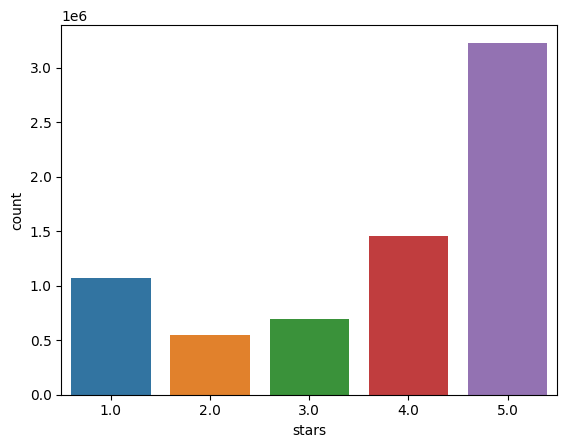

In [ ]:
df_review1= df_review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars')
df_review1.show()
temp=df_review1.toPandas()
sns.barplot(x='stars', y='count', data=temp)

**Explore null values**


In [ ]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



**Distribution of active versus inactive businesses**

<Axes: xlabel='is_open', ylabel='count'>

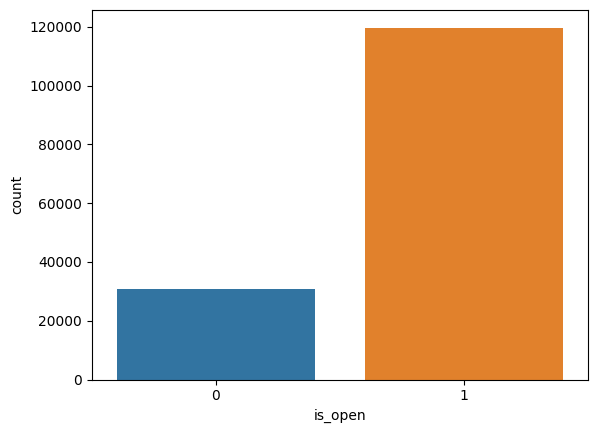

In [ ]:
df_open = df_business.groupBy('is_open').count().toPandas()
df_open
sns.barplot(x='is_open', y='count', data=df_open)

**Distribution of businesses in the most reviewed cities**

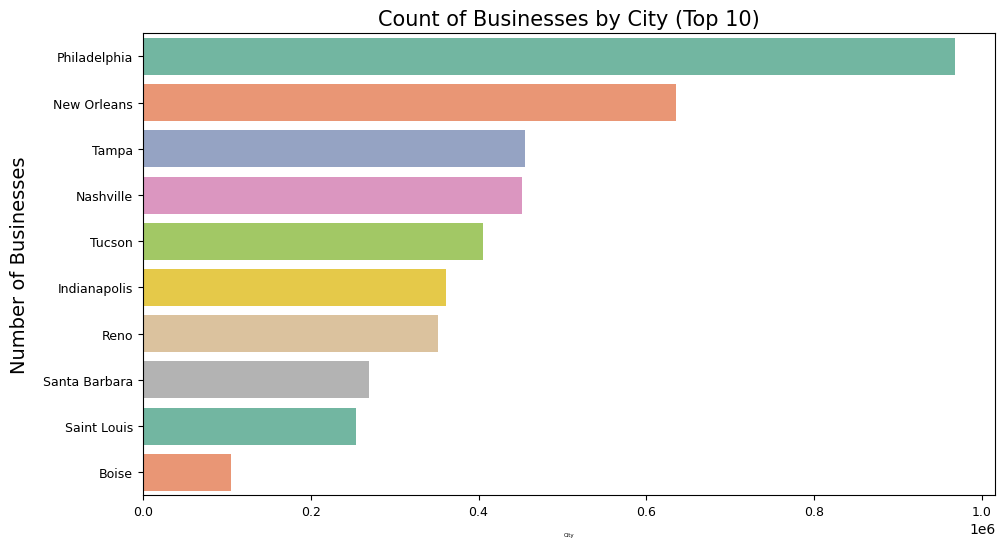

In [ ]:
topcity = merge_city.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
topcity.head()

plt.figure(figsize=(11,6))
sns.barplot(y=topcity['city'].values[:10], x=topcity['count'].values[:10],palette=sns.color_palette("Set2"))
plt.ylabel('Number of Businesses', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=4, labelpad=10)
plt.title('Count of Businesses by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=9)
plt.xticks(rotation=0)
plt.show()

**Distribution of most reviewed businesses across all industries**

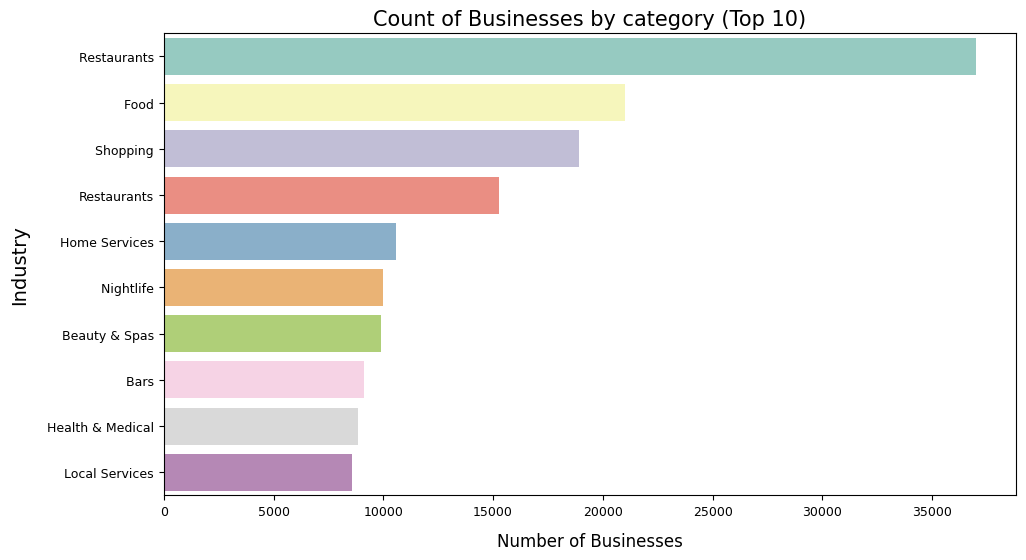

In [ ]:
topcat = individual_category.groupBy('Industry').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
topcat.head()
plt.figure(figsize=(11,6))
sns.barplot(y=topcat['Industry'].values[:10], x=topcat['count'].values[:10], palette=sns.color_palette("Set3"))
plt.ylabel('Industry', fontsize=14, labelpad=10)
plt.xlabel('Number of Businesses', fontsize=12, labelpad=10)
plt.title('Count of Businesses by category (Top 10)', fontsize=15)
plt.tick_params(labelsize=9)
plt.xticks(rotation=0)
plt.show()

# **II.Text Pre-processing**

For sentiment analysis, we first need to pre-process our comments

**STEP 1. Remove punctuations**

In [ ]:
def remove_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    no_pun = regex.sub(" ", text) 
    return no_pun

**STEP 2. Classify reviews as positive or negative sentiment, where star greater than 3 is labeled as 1.** **bold text**

In [ ]:
def convert_rating(rating):
    star_ratings = int(rating)
    if rating >=3: return 1
    else: return 0

# functions to remove punctuation and convert star ratings
pun_remove = udf(lambda x: remove_punct(x))
convert = udf(lambda x: convert_rating(x))

# apply above functions to our datasets
processed_review = df_review.select('review_id', pun_remove('text'), convert('stars'))

processed_review = processed_review.withColumnRenamed('<lambda>(text)', 'text')\
                     .withColumn('label', processed_review["<lambda>(stars)"].cast(IntegerType()))\
                     .drop('<lambda>(stars)')\
                     .limit(1000000)

In [ ]:
#Display reviews after processing
processed_review.show(5)

+--------------------+--------------------+-----+
|           review_id|                text|label|
+--------------------+--------------------+-----+
|KU_O5udG6zpxOg-Vc...|If you decide to ...|    1|
|BiTunyQ73aT9WBnpR...|I ve taken a lot ...|    1|
|saUsX_uimxRlCVr67...|Family diner  Had...|    1|
|AqPFMleE6RsU23_au...|Wow   Yummy  diff...|    1|
|Sx8TMOWLNuJBWer-0...|Cute interior and...|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



**STEP 3. Tokenize comments and remove stop words**

In [ ]:
# tokenize reviews
tokenize = Tokenizer(inputCol="text", outputCol="words")
tokenized_review = tokenize.transform(processed_review)

# remove stop words
remove_stopword = StopWordsRemover(inputCol='words', outputCol='words_new')
tokenized_review = remove_stopword.transform(tokenized_review)

In [ ]:
#Display reviews after tokenization and removal of stop words
tokenized_review.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+
|           review_id|                text|label|               words|           words_new|
+--------------------+--------------------+-----+--------------------+--------------------+
|KU_O5udG6zpxOg-Vc...|If you decide to ...|    1|[if, you, decide,...|[decide, eat, , a...|
|BiTunyQ73aT9WBnpR...|I ve taken a lot ...|    1|[i, ve, taken, a,...|[ve, taken, lot, ...|
|saUsX_uimxRlCVr67...|Family diner  Had...|    1|[family, diner, ,...|[family, diner, ,...|
|AqPFMleE6RsU23_au...|Wow   Yummy  diff...|    1|[wow, , , yummy, ...|[wow, , , yummy, ...|
|Sx8TMOWLNuJBWer-0...|Cute interior and...|    1|[cute, interior, ...|[cute, interior, ...|
+--------------------+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



**STEP 4: CountVectorisation and tf-Idf (term frequency and inverse document frequency)** 

In [ ]:
# CountVectorization
CountVec = CountVectorizer(inputCol='words_new', outputCol='tf')
CountVec_model = CountVec.fit(tokenized_review)
count_vectorized_reviews = CountVec_model.transform(tokenized_review)

NameError: ignored

In [ ]:
# tf-idf
tf_idf = IDF().setInputCol('tf').setOutputCol('tf_idf')
tf_idf_model = tf_idf.fit(count_vectorized_reviews)
tf_idf_review = tf_idf_model.transform(count_vectorized_reviews)

In [ ]:
#Display reviews after countvectorization and tfidf
tf_idf_review.show(5)

# **III. Supervised Machine Learning Predictive Modeling**

Models include:

1. Naive Bayes

2. Support Vector Machine

3. Logistic Regression

4. Random Forest



**1. Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", weightCol="weight")

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [ ]:
stages = []
# 1. clean data and tokenize sentences using RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W+")
stages += [regexTokenizer]

# 2. CountVectorize the data
cv = CountVectorizer(inputCol="tokens", outputCol="token_features", minDF=2.0)#, vocabSize=3, minDF=2.0
stages += [cv]

# 3. Convert the labels to numerical values using binariser
indexer = StringIndexer(inputCol="label", outputCol="label1")
stages += [indexer]

# 4. Vectorise features using vectorassembler
vecAssembler = VectorAssembler(inputCols=['token_features'], outputCol="features")
stages += [vecAssembler]

[print('\n', stage) for stage in stages]

In [ ]:
stages = []
# 1. clean data and tokenize sentences using RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W+")
stages += [regexTokenizer]

# 2. CountVectorize the data
cv = CountVectorizer(inputCol="tokens", outputCol="token_features", minDF=2.0)#, vocabSize=3, minDF=2.0
stages += [cv]

# 3. Convert the labels to numerical values using binariser
indexer = StringIndexer(inputCol="label", outputCol="label1")
stages += [indexer]

# 4. Vectorise features using vectorassembler
vecAssembler = VectorAssembler(inputCols=['token_features'], outputCol="features")
stages += [vecAssembler]

[print('\n', stage) for stage in stages]


 RegexTokenizer_5edf07f9deeb

 CountVectorizer_eaacfaefa196

 StringIndexer_ce825f6570e2

 VectorAssembler_13f76b4c4a0c


[None, None, None, None]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(tfidf_df).transform(tfidf_df)

In [ ]:
train_nb, test_nb = data.randomSplit([0.8, 0.2], seed = 2018)

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model_nb = nb.fit(train_nb)

In [ ]:
predictions = model_nb.transform(test_nb)
# Select results to view
predictions.limit(10).select("label", "prediction", "probability").show(truncate=False)

+-----+----------+-------------------------------------------+
|label|prediction|probability                                |
+-----+----------+-------------------------------------------+
|1    |1.0       |[4.5902986561809365E-11,0.9999999999540969]|
|1    |1.0       |[4.3455584210085304E-7,0.9999995654441579] |
|1    |1.0       |[5.9377322148630876E-8,0.9999999406226778] |
|0    |0.0       |[0.9969209935083592,0.0030790064916408834] |
|1    |1.0       |[0.002129835933854133,0.9978701640661459]  |
|1    |1.0       |[0.0030842835789838745,0.9969157164210161] |
|1    |1.0       |[2.638334185789453E-17,1.0]                |
|1    |1.0       |[7.22552172467018E-8,0.9999999277447827]   |
|1    |1.0       |[1.626316976449768E-13,0.9999999999998375] |
|0    |0.0       |[0.9999999999999987,1.379233476913504E-15] |
+-----+----------+-------------------------------------------+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Test Area Under ROC: ", accuracy)

Test Area Under ROC:  0.8496871988138883


**2. Support Vector Machine**

In [ ]:
# SVM model
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb, numIterations, regParam=regParam)

# predict
test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
scoreAndLabels_test = test_lb.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction", "label"])

In [ ]:
#Model Evaluation
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

In [ ]:
vocabulary = cvModel.vocabulary
weights = svm.weights.toArray()
svm_coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

svm_coeffs_df.sort_values('weight').head(20)

**3. Logistic Regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression( labelCol='label', maxIter=10)
lrModel = lr.fit(train_nb)

In [ ]:
lrModel = lr.fit(train)
lr_pred = lrModel.transform(test)
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = f1_eval.evaluate(lr_pred)
print("F1 score: %.4f" % lr_f1)

**4. Random Forest**

In [ ]:
from pyspark.ml.classification import (DecisionTreeClassifier, RandomForestClassifier, 
                                      GBTClassifier)
from pyspark.ml import Pipeline


In [ ]:
# Creating a vector assembly 
assembler = VectorAssembler(inputCols=['tfidf'], outputCol='features')
final_data = assembler.transform(tfidf_df)

In [ ]:
final_data.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_new: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'label', outputCol = 'label1')
outputFixed = indexer.fit(final_data).transform(final_data)
outputFixed.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_new: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label1: double (nullable = false)



In [ ]:
outputFixed.printSchema()

final_df = outputFixed.select('features', 'label1')
final_df.show(3)

root
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_new: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label1: double (nullable = false)

+--------------------+------+
|            features|label1|
+--------------------+------+
|(202063,[0,1,2,6,...|   0.0|
|(202063,[0,7,14,1...|   0.0|
|(202063,[0,2,3,13...|   0.0|
+--------------------+------+
only showing top 3 rows



In [ ]:
# Scaling the data 
scaler = StandardScaler(inputCol='features',outputCol='scaledFeat')
final_data = scaler.fit(final_data).transform(final_data)

In [ ]:
train_rf, test_rf = final_df.randomSplit([0.8, 0.2])

In [ ]:
# Building the random forest model
gb = GBTClassifier(labelCol = 'label1', featuresCol = 'scaledFeat')
gb_model = gb.fit(train)

In [ ]:
rf_predictions = rf_model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binary_evaluator = BinaryClassificationEvaluator(labelCol = 'label1')

# **IV. Yelp Review Recommendation System - Alternating Least Square algorithm**

In [ ]:
# We found that business dataset has some columns which has missing values and do not add any value to our model

yelp_business = yelp_business.select('business_id','name', 'stars', 
                                 'review_count', 'attributes', 
                                 'categories', 'city').withColumnRenamed('stars', 'stars_restaurant')

yelp_business = yelp_business.filter((yelp_business['city'] == 'Philadelphia') & (yelp_business.categories.contains('Restaurants'))).drop('city')

In [ ]:
# We filter the business dataset and apply inner join it with review dataset to perform the factorization algorithm 
yelp_restaurant_review = yelp_review.select('*')
yelp_restaurant_review = yelp_restaurant_review.join(yelp_business, on='business_id', how='inner')
yelp_restaurant_review.select(['business_id', 'user_id', 'stars']).show(5)

In [ ]:
# Plotting a histogram of frequency of star ratings of restaurants from review dataset
%matplotlib inline
reviews = yelp_restaurant_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]
plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='pink',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [ ]:
# Plotting a histogram of frequency of different star rating restaurants from the business dataset
restaurant_reviews = yelp_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]
plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='purple',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [ ]:
# Defining the categories of restaurants 
restaurant_categories = yelp_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]
print(restaurant_categories_list)

In [ ]:
# Define words from review
word = " ".join(review for review in restaurant_categories_list)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# elimiminating some common words
text = word.replace('Restaurants', "")
text = word.replace('bars', "")
text = word.replace('New', "")
text = word.replace('Food', "")
text = word.replace('Planning', "")
text = word.replace('Arts', "")
text = word.replace('Entertainment', "")
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We find the words FOOD, AMERICAN, BREAKFAST and BRUNCH are maximum used words in the reviews

**BUILDING THE RECOMMENDER SYSTEM**


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType

In [ ]:
# Converting and transforming data into dataframe

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(yelp_restaurant_review).transform(yelp_restaurant_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

In [ ]:
transformed.show(5)

In [ ]:
# Split the data into train and test data sets in 80:20 ratio
(train, test) = transformed.randomSplit([0.8, 0.2])

In [ ]:
from heapq import nlargest
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.recommendation import ALS
from pyspark import SparkContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [ ]:
# Building the system on ALS algorithm 

als = ALS(maxIter=5,
        regParam=0.09, 
        rank=25,
        userCol="user_id_index", 
        itemCol="business_id_index",
        ratingCol="stars", 
        coldStartStrategy="drop", 
        nonnegative=True)

recommender =als.fit(train)

To evaluate the recommender model, we use the metric Root Mean Square Error

In [ ]:
evaluator= RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions= recommender.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

RESULTS OF RECOMMENDER SYSTEM

Checking out the results of the system for a random user_id= 952

In [ ]:
test = recommender.recommendForAllUsers(20).filter(col('user_id_index')==952).select("recommendations").collect()
Restaurant_recm = []
for item in test[0][0]:        
    Restaurant_recm.append(item.business_id_index)
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(Restaurant_recm,IntegerType()).toDF("business_id_index")
transformed\
.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==7313)\
.show()
restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()